# Particle Filter for the Lorenz63 model

First, the usual imports

In [1]:
import sys
sys.path.append('..')
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("seaborn-notebook")
from DA_PoC.dynamicalsystems.lorenz63 import Lorenz63Model
from DA_PoC.filters.standardPF import BootstrapPF
from DA_PoC.filters.optimalparticlefilter import OptimalKPF
%matplotlib inline

ModuleNotFoundError: No module named 'dynamicalsystems'

## Model properties

In [ ]:
# Properties of the model
dt = 0.02
Lorenz63Model.dt = dt
state_dimension=3
obs_dimension = 1
H = np.c_[np.eye(obs_dimension), np.zeros((obs_dimension, state_dimension - obs_dimension))]
sigobs = 5
R = sigobs * np.eye(obs_dimension)
Q = np.eye(state_dimension)

## Truth / Observations generation
Let us generate the "truth", and prepare the observations to be assimilated

In [ ]:
truth = Lorenz63Model()
burn = 1000
truth.set_initial_state(-burn * dt, np.array([0, 1, 0]))
truth.forward(burn)  # Burn-in period

period_assim = 1
def generate_observations(i):
    truth.forward(period_assim)
    y = truth.state_vector[:, -1] + np.random.multivariate_normal(np.zeros(3), cov=np.eye(3)) * sigobs
    return truth.t[-1], y

observations_vector = []
for i in range(2000):
    observations_vector.append(generate_observations(i))


How does the trajectories look like

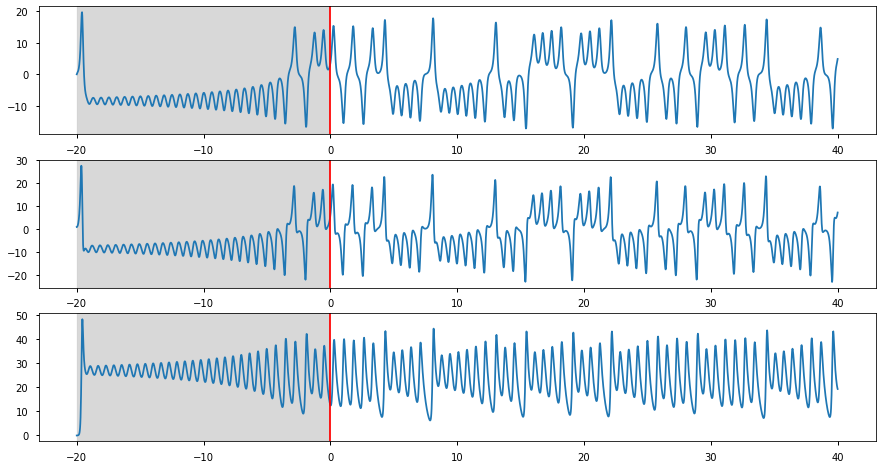

In [ ]:
plt.figure(figsize=(15,8))
plt.title(r"Trajectories of the Lorenz63 model")
for i, traj in enumerate(truth.state_vector, 1):
    plt.subplot(3, 1, i)
    plt.plot(truth.t, traj)
    plt.axvspan(-burn * dt, 0, color='grey', alpha=0.5)
    plt.axvline(x=0, color='red')
    # plt.xlim(left=0)


## Bootstrap (Standard) Particle Filter
Let us set the parameters for the Bootstrap particle filter

In [ ]:
Nparticles = 200
assimilation_steps = 250

PF = BootstrapPF(state_dimension=3, Nparticles=Nparticles, R=R)
PF.H = H


We set the forward model with an additive Gaussian noise

In [ ]:
PF.set_forwardmodel(lambda x: Lorenz63Model.integrate(
    0, x, period_assim)[1][:, -1] + np.random.multivariate_normal(np.zeros(3), cov=Q))

Generation of the initial particles

In [ ]:
PF.generate_particles(
    mean=truth.state_vector[:, -1],
    cov=sigobs * np.eye(state_dimension),
)

In [ ]:
dPF = PF.run(assimilation_steps, lambda i: observations_vector[i], full_obs=True, ESS_lim=None)

In [ ]:

est = np.array(dPF["estimates"])[:, 0, :].T
std = np.sqrt(np.array(dPF["estimates"])[:, 1, :]).T
obs = np.array(dPF["observations"]).T
wei = np.array(dPF["weights"])
# for i in range(assimilation_steps):
#     plt.scatter(
#         period_assim * (i + 1) * np.ones(Nparticles) * dt,
#         np.asarray(dPF["particles"])[i, 0, :],
#         marker="o",
#         c="cyan",
#         s=300 * wei[i, :],
#     )
# v_ = [
#     PF.weighted_moments(
#         np.array(dPF["particles"])[i, :, :],
#         np.array(dPF["weights"])[i, :],
#     )[1]
#     for i in range(assimilation_steps)
# ]

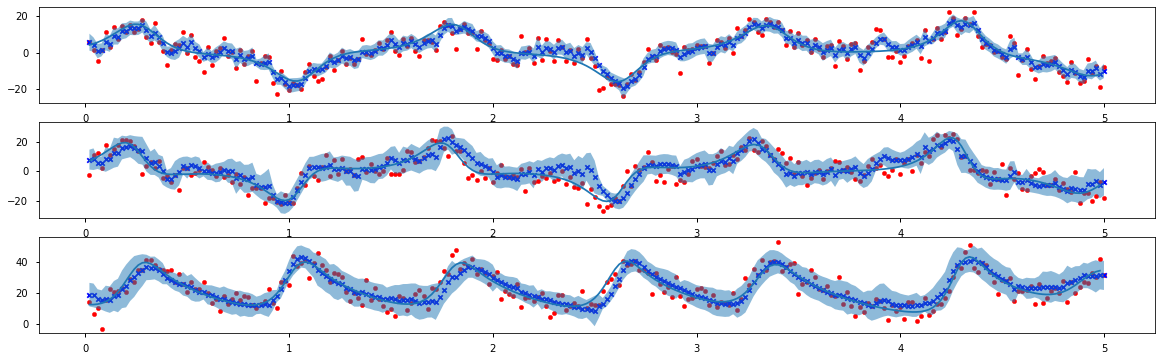

In [ ]:
plt.figure(figsize=(20,6))
plt.title(r'Bootstrap PF on the Lorenz63 problem')
for i in range(3):
    plt.subplot(3, 1, i + 1)
    plt.plot(truth.t[(burn +1):burn+assimilation_steps], truth.state_vector[i, (burn+1):burn + assimilation_steps])
    plt.scatter(dPF["time"], obs[i, :], marker="o", c="red", s=20)
    plt.scatter(dPF["time"], est[i, :], marker="x", color="blue", s=20)
    plt.fill_between(dPF['time'], (est + 3*std)[i, :],(est - 3*std)[i, :], alpha=0.5)
plt.show()

In [ ]:
analysis_error = est[:, 1:] - truth.state_vector[:, (burn + 1):burn + assimilation_steps]
observation_error = obs[:, 1:] - truth.state_vector[i, (burn + 1):burn + assimilation_steps]
ea = (analysis_error**2).mean()
eo = (observation_error**2).mean()
print(f"{'Analysis error:': >20} {ea:>20}")
print(f"{'Observation error:': >20} {eo:>20}")

     Analysis error:   10.094493210695326
  Observation error:    471.2191247075085


## PF with KF proposal density

In [ ]:
OKPF = OptimalKPF(state_dimension=3, Nparticles=Nparticles, R=R, Q=Q)
OKPF.H = H
OKPF.set_forwardmodel(lambda x: Lorenz63Model.integrate(
    0, x, period_assim)[1][:, -1] + np.random.multivariate_normal(np.zeros(3), cov=Q))
OKPF.generate_particles(
    mean=truth.state_vector[:, -1],
    cov=sigobs * np.eye(state_dimension),
)

In [ ]:
period_assim = 1
dOKPF = OKPF.run(assimilation_steps, lambda i: observations_vector[i], full_obs=True, ESS_lim=None)

In [ ]:
est = np.array(dOKPF["estimates"])[:, 0, :].T
std = np.sqrt(np.array(dOKPF["estimates"])[:, 1, :]).T
obs = np.array(dOKPF["observations"]).T
wei = np.array(dOKPF["weights"])

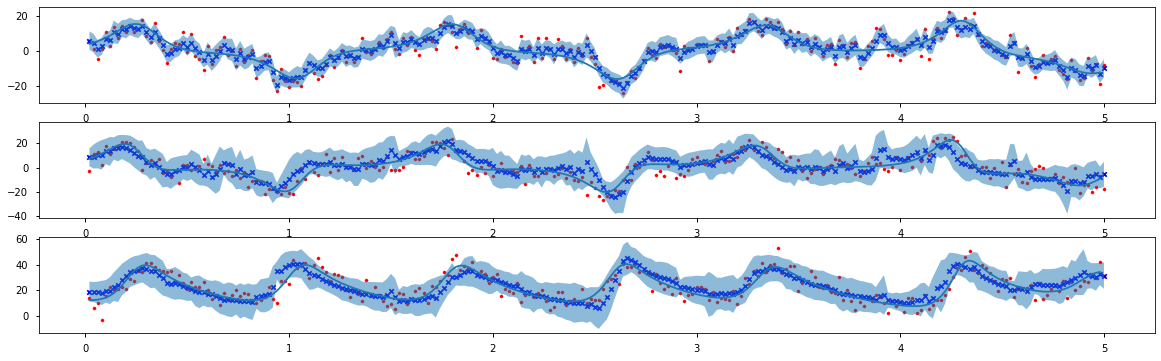

In [ ]:
plt.figure(figsize=(20,6))
plt.title(r'OPKF on the Lorenz63 model')
for i in range(3):
    plt.subplot(3, 1, i + 1)
    plt.plot(truth.t[(burn +1):burn+assimilation_steps], truth.state_vector[i, (burn+1):burn + assimilation_steps])
    plt.scatter(dPF["time"], obs[i, :], marker="o", c="red", s=10)
    plt.scatter(dPF["time"], est[i, :], marker="x", color="blue", s=20)
    plt.fill_between(dPF['time'], (est + 3*std)[i, :],(est - 3*std)[i, :], alpha=0.5)
plt.show()

In [ ]:
analysis_error = est[:, 1:] - truth.state_vector[:, (burn + 1):burn + assimilation_steps]
observation_error = obs[:, 1:] - truth.state_vector[i, (burn + 1):burn + assimilation_steps]
ea = (analysis_error**2).mean()
eo = (observation_error**2).mean()
print(f"{'Analysis error:': >20} {ea:>20}")
print(f"{'Observation error:': >20} {eo:>20}")

     Analysis error:    19.28674737037352
  Observation error:    471.2191247075085
